# Adult Census Income Prediction

## Project Goal

The goal here is to predict whether someone makes more than $50,000/year using census data.  
this notebook walks through the whole pipeline: loading, cleaning, exploring, feature engineering, splitting, scaling, modeling, and evaluation.  
we use the custom courselib library together with newly created custom functions and try to show clear visuals and explanations at each step.

## Pipeline Overview

1.  **Load & Clean Data**
2.  **Exploratory Data Analysis (EDA)**
3.  **Feature Engineering & Preprocessing**
    -   3.1 Category Merging
    -   3.2 Encode categorical variables (target, ordinal, one-hot, frequency)
    -   3.3 Feature Correlations
    -   3.4 Splitting the Data
    -   3.5 Scale Numerical Features
4.  **Model Training**
    -   4.1 Base model
    -   4.2 
    -   4.3 
5.  **Hyperparameter Tuning**
6.  **Model Evaluation & Comparison**

## 1 Load & Clean Data

In [287]:
# Enable autoreloading of imported modules
%load_ext autoreload
%autoreload 2

import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# Add the repo root to access the courselib
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
courselib_path = os.path.join(repo_root, "AppliedML", "courselib")
if courselib_path not in sys.path:
    sys.path.insert(0, courselib_path)
    print(f"{courselib_path} added to sys.path.")
else:
    print("Courselib path already in sys.path.")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Courselib path already in sys.path.


As this project is supposed to integrate well with the courselib, we have downloaded the current GitHub Repo up to week 11 and our code will be integrated within courselib libraries.

In [288]:
from utils.loaders import load_uciadult

# ensure the data directory exists / else create it
os.makedirs('data', exist_ok=True)

# get the data
df = load_uciadult()

Loading from local `data/adult.data`...


In [289]:
# check for missing values
df.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64

1.  **Handle Duplicates**: We remove any duplicate rows from the dataset.
2.  **Handle Missing Values**: Instead of dropping rows with missing values, we treat them as the separate category  `Missing` in categorical columns. This allows us to preserve potentially useful information — for example, individuals with unknown workclass or occupation might share certain income patterns. This approach is especially appropriate for categorical variables, where missingness itself may contain information. Fortunately, this data set does not contain other missing data.


In [290]:
from utils.preprocessing import preprocess_data

# preprocessing of  the data
df = preprocess_data(df)

24 duplicate observations in the dataset were removed.


In [291]:
# first glimpse into the data set
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


# 2. Exploratory Data Analysis (EDA)

In [292]:
# basic info about the data set 
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32537 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             32537 non-null  int64   
 1   workclass       32537 non-null  category
 2   fnlwgt          32537 non-null  int64   
 3   education       32537 non-null  category
 4   education-num   32537 non-null  int64   
 5   marital-status  32537 non-null  category
 6   occupation      32537 non-null  category
 7   relationship    32537 non-null  category
 8   race            32537 non-null  category
 9   sex             32537 non-null  category
 10  capital-gain    32537 non-null  int64   
 11  capital-loss    32537 non-null  int64   
 12  hours-per-week  32537 non-null  int64   
 13  native-country  32537 non-null  category
 14  income          32537 non-null  int64   
dtypes: category(8), int64(7)
memory usage: 2.2 MB


In [293]:
# summary stats about the variables
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,income
count,32537.000000,3.253700e+04,32537.000000,32537.000000,32537.000000,32537.000000,32537.000000
mean,38.585549,1.897808e+05,10.081815,1078.443741,87.368227,40.440329,0.240926
std,13.637984,1.055565e+05,2.571633,7387.957424,403.101833,12.346889,0.427652
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.369930e+05,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


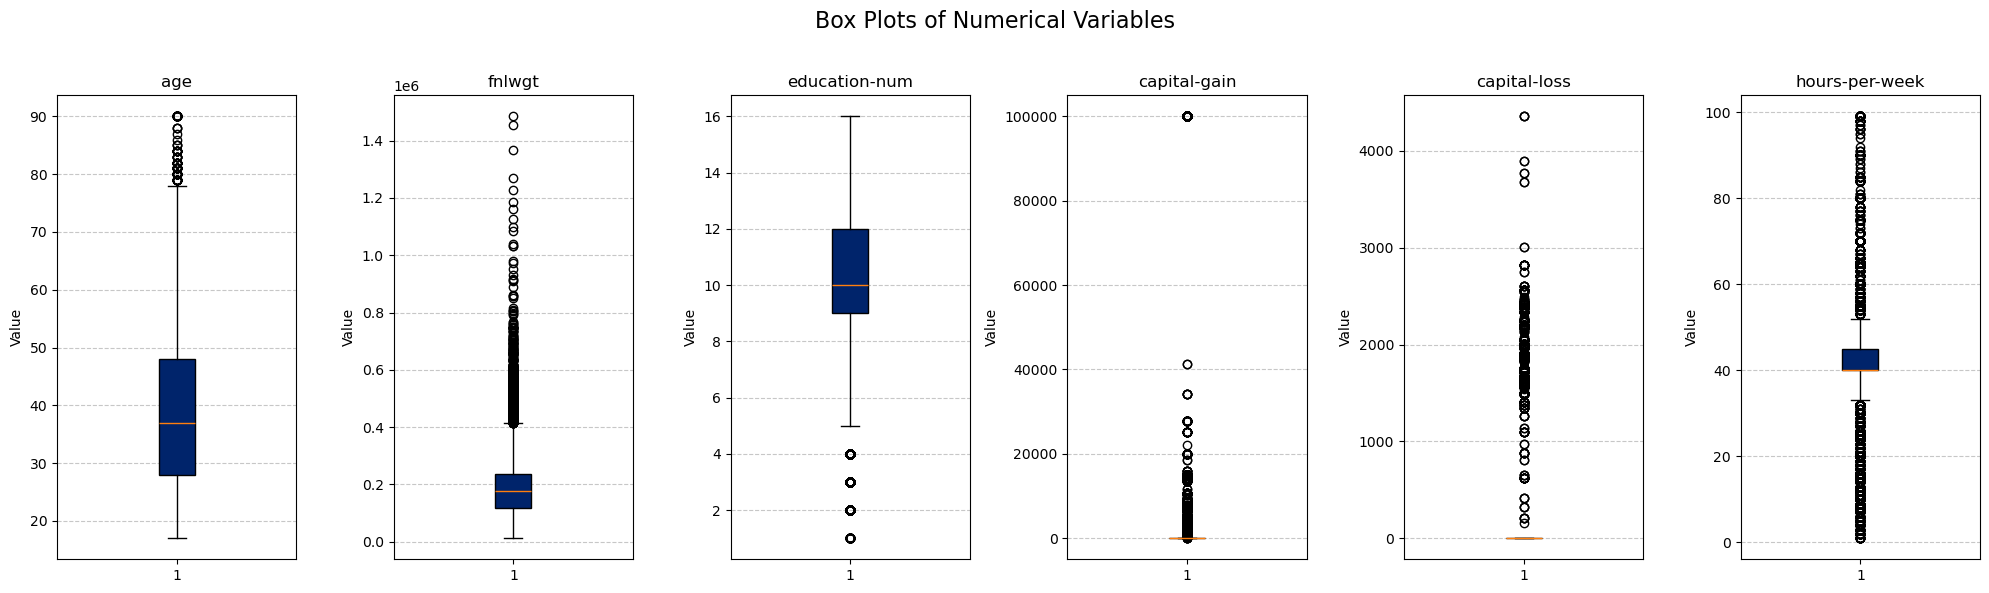

In [294]:
# boxplots of the numerical cols 
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
if 'income' in numerical_cols:
    numerical_cols.remove('income')

# grid of box plots
fig, axes = plt.subplots(nrows=1, ncols=len(numerical_cols), figsize=(20, 6))
fig.suptitle('Box Plots of Numerical Variables', fontsize=16)

for i, col in enumerate(numerical_cols):
    ax = axes[i]
    ax.boxplot(df[col], patch_artist=True, boxprops=dict(facecolor='#00246B'))
    ax.set_title(col, fontsize=12)
    ax.set_ylabel('Value')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

- High Skewness: `fnlwgt`, `capital-gain`, and `capital-loss` are heavily right-skewed. For `capital-gain`, and `capital-loss`, the majority of values are zero, with a few very large outliers. This indicates that these events are rare but have a high magnitude when they occur. `fnlwgt`is dropped as that variable is difficult to interpret. (It indicates how many people in the population a particular record represents and is therefore not an individual attribute and also highly skewed with high variance.)
- Moderate Outliers: age and hours-per-week also show outliers but have more symmetric distributions.

In [295]:
from utils.preprocessing import log_transform

# skewed columns and apply log transformation to have them on a more similar scale
skewed_cols = ['capital-gain', 'capital-loss']
df = log_transform(df, skewed_cols)
df = df.drop('fnlwgt', axis=1, inplace=True) # fnlwgt is difficult to interpret

The following chart shows a class imbalance in the data: approximately 76% of individuals earn <=50K (low-earners = 0) while only 24% earn >50K (high-earners = 1). A model trained on this data might become biased towards predicting the majority class. Standard accuracy can be a misleading metric; a naive model that always predicts <=50K would be ~76% accurate but completely useless.

In [296]:
# distribution of the target variable
plt.figure(figsize=(7, 5))
bars = df['income'].value_counts().sort_index().plot(
    kind='bar',
    color=['#00246B', '#CADCFC'],
)
plt.title('Class Balance of Income', fontsize=16)
plt.xlabel('Income (0 = <=50K, 1 = >50K)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['<=50K', '>50K'], rotation=0, fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
counts = df['income'].value_counts().sort_index()
labels = ['<=50K', '>50K']
for i, count in enumerate(counts):
    pct = count / counts.sum() * 100
    plt.text(i, count + 200, f'{pct:.1f}%', ha='center', fontsize=11)
plt.show()

TypeError: 'NoneType' object is not subscriptable

<Figure size 700x500 with 0 Axes>

The age distribution shows that individuals earning over $50K are, on average, older than those earning less. The high-income group's distribution peaks between the late 30s and early 50s, suggesting that income potential increases with age and experience before declining.

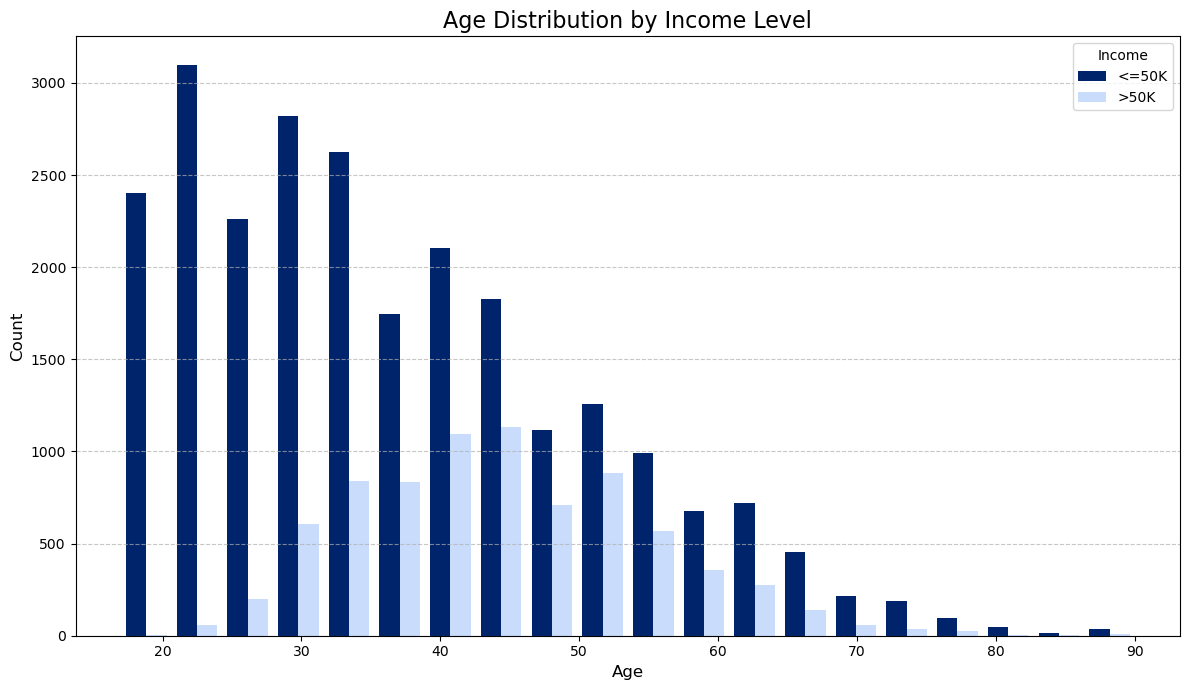

In [ ]:
# relationship between income and age
plt.figure(figsize=(12, 7))

# separate data for the two income categories
over50k = df[df['income'] == 0]['age']
below50k = df[df['income'] == 1]['age']

# side-by-side histograms
plt.hist([over50k, below50k], bins=20, color=['#00246B', '#CADCFC'], label=['<=50K', '>50K'])
plt.title('Age Distribution by Income Level', fontsize=16)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Income')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

There seems to exist a strong, positive correlation between education and income. The likelihood of earning over $50K increases directly with the level of education, which seems economically reasonable. This clear ordering suggests the use of ordinal encoding for this feature.

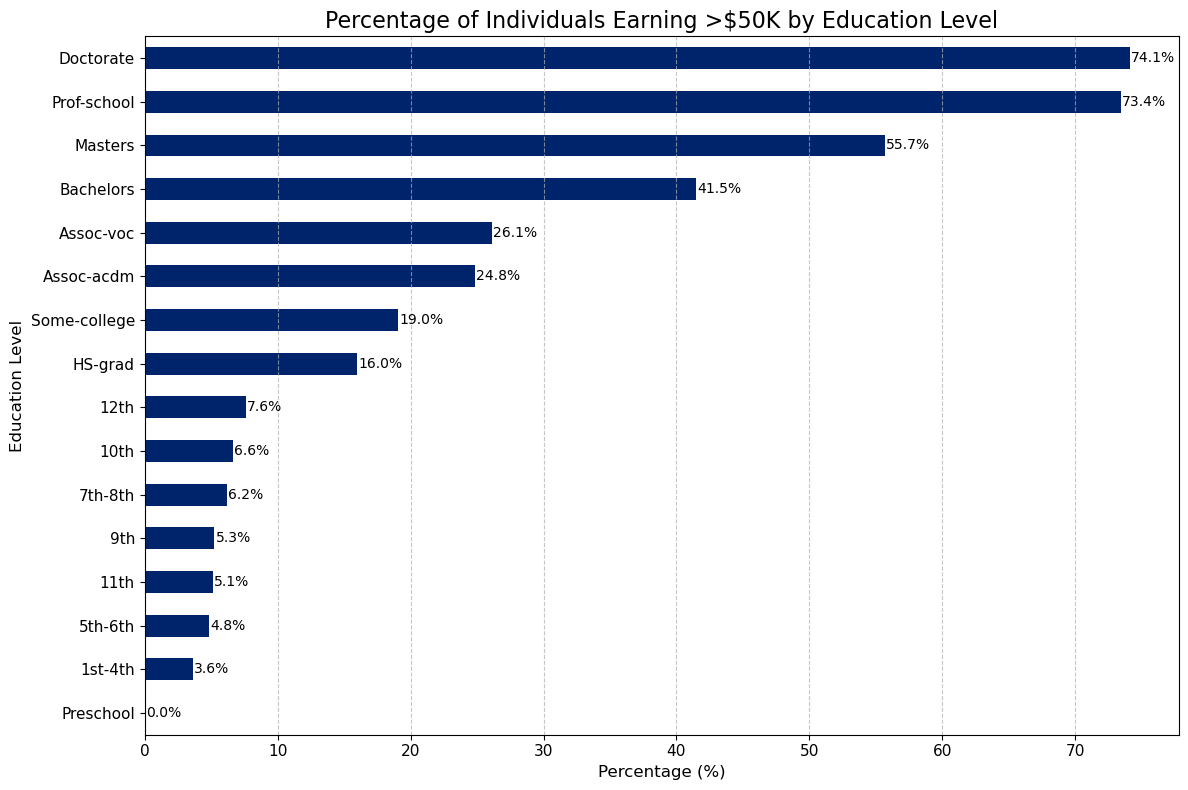

In [ ]:
education_income_pct = df.groupby('education', observed=False)['income'].mean().sort_values() * 100

# plot
plt.figure(figsize=(12, 8))
bars = education_income_pct.plot(kind='barh', color='#00246B')
plt.title('Percentage of Individuals Earning >$50K by Education Level', fontsize=16)
plt.xlabel('Percentage (%)', fontsize=12)
plt.ylabel('Education Level', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# percentage labels
for bar in bars.patches:
    plt.text(bar.get_width() + 0.1,
             bar.get_y() + bar.get_height() / 2,
             f'{bar.get_width():.1f}%',
             va='center',
             ha='left',
             fontsize=10)

plt.tight_layout()
plt.show()

This chart shows the average hours worked per week for each workclass, with bar color indicating the proportion of high-income earners. `Self-emp-inc` stands out with both the highest average hours and the greatest income potential (55.7%). Conversely, categories like `Without-pay` and `Never-worked` show zero high-income potential. The `Missing` category also has a low income potential (10.4%), suggesting that the reason for the missing data might be correlated with lower-paying or non-standard work situations.

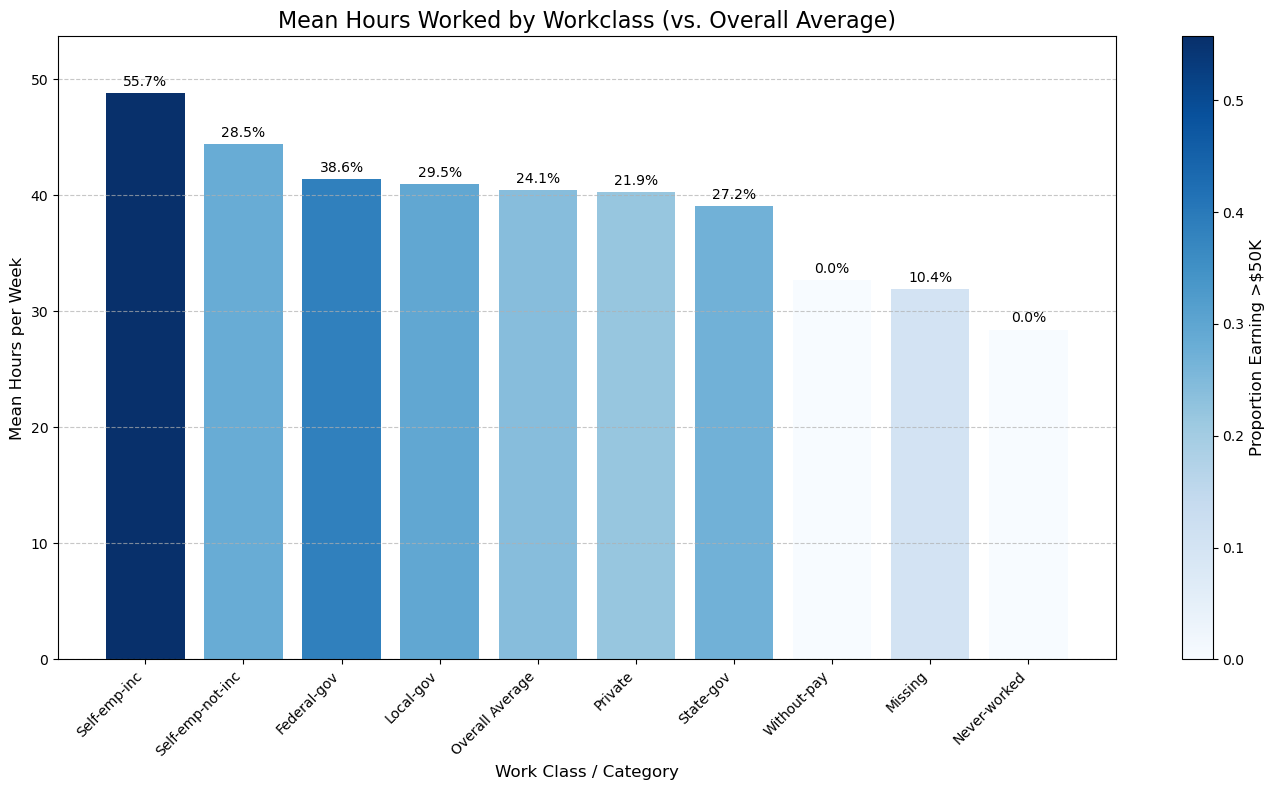

In [ ]:
workclass_stats = df.groupby('workclass', observed=False).agg(
    mean_hours=('hours-per-week', 'mean'),
    pct_high_income=('income', 'mean')
)
overall_stats = pd.DataFrame({
    'mean_hours': [df['hours-per-week'].mean()],
    'pct_high_income': [df['income'].mean()]
}, index=['Overall Average'])

# merge workclass stats with overall stats
combined_stats = pd.concat([workclass_stats, overall_stats]).sort_values('mean_hours', ascending=False)

# plot and colormap
fig, ax = plt.subplots(figsize=(14, 8))
cmap = plt.get_cmap('Blues')
norm = plt.Normalize(vmin=combined_stats['pct_high_income'].min(), vmax=combined_stats['pct_high_income'].max())
colors = cmap(norm(combined_stats['pct_high_income'].values))
bars = ax.bar(combined_stats.index, combined_stats['mean_hours'], color=colors)

# color bar for the mean proportion of high-earners
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, pad=0.05)
cbar.set_label('Proportion Earning >$50K', fontsize=12)

# text labels for the proportions
labels = [f'{pct*100:.1f}%' for pct in combined_stats['pct_high_income']]
ax.bar_label(bars, labels=labels, padding=3, fontsize=10, color='black')
ax.set_title('Mean Hours Worked by Workclass (vs. Overall Average)', fontsize=16)
ax.set_xlabel('Work Class / Category', fontsize=12)
ax.set_ylabel('Mean Hours per Week', fontsize=12)
ax.set_ylim(0, combined_stats['mean_hours'].max() * 1.1)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# 3. Feature Engineering


In [ ]:
# counts and proportions of every categorical col
categorical_cols_merged = df.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols_merged:
    print(f"--- Feature: {col} ---")
    
    # summary of each group within a col
    summary_df = pd.DataFrame({
        'Count': df[col].value_counts(),
        'Proportion (%)': (df[col].value_counts(normalize=True) * 100).round(2)
    })
    print(summary_df)
    print("_"*40 + "\n")

--- Feature: workclass ---
                  Count  Proportion (%)
workclass                              
Private           22673           69.68
Self-emp-not-inc   2540            7.81
Local-gov          2093            6.43
Missing            1836            5.64
State-gov          1298            3.99
Self-emp-inc       1116            3.43
Federal-gov         960            2.95
Without-pay          14            0.04
Never-worked          7            0.02
________________________________________

--- Feature: education ---
              Count  Proportion (%)
education                          
HS-grad       10494           32.25
Some-college   7282           22.38
Bachelors      5353           16.45
Masters        1722            5.29
Assoc-voc      1382            4.25
11th           1175            3.61
Assoc-acdm     1067            3.28
10th            933            2.87
7th-8th         645            1.98
Prof-school     576            1.77
9th             514            1

### 3.1 Category Merging

Before encoding, we will merge some categories to reduce dimensionality and group similar items to simplify features and help the model generalize better. Thus several possible categorical variables are analyzed and discussed.


In [ ]:
# to modify the dataset
df = df.copy()

In [ ]:
# binary feature for US vs. rest of the world as the dataset is mostly US-related
df['is_from_us'] = (df['native-country'] == 'United-States').astype(int)
df.drop('native-country', axis=1, inplace=True)
print("Value counts for 'is_from_us':\n")
print(df['is_from_us'].value_counts())

Value counts for 'is_from_us':

is_from_us
1    29153
0     3384
Name: count, dtype: int64


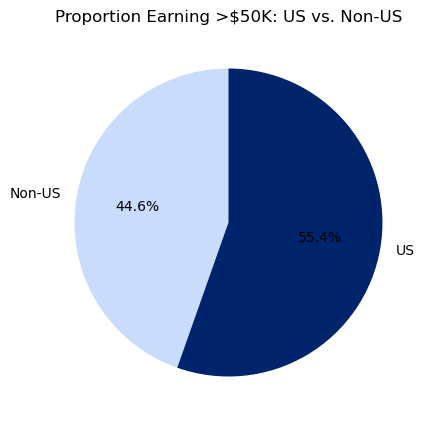

In [ ]:
# pie chart for US vs. Non-US
us_vs_nonus = df.groupby('is_from_us')['income'].mean()
labels = ['Non-US', 'US']
plt.figure(figsize=(5, 5))
plt.pie(us_vs_nonus, labels=labels, autopct='%1.1f%%', colors=['#CADCFC', '#00246B'], startangle=90)
plt.title('Proportion Earning >$50K: US vs. Non-US')
plt.show()

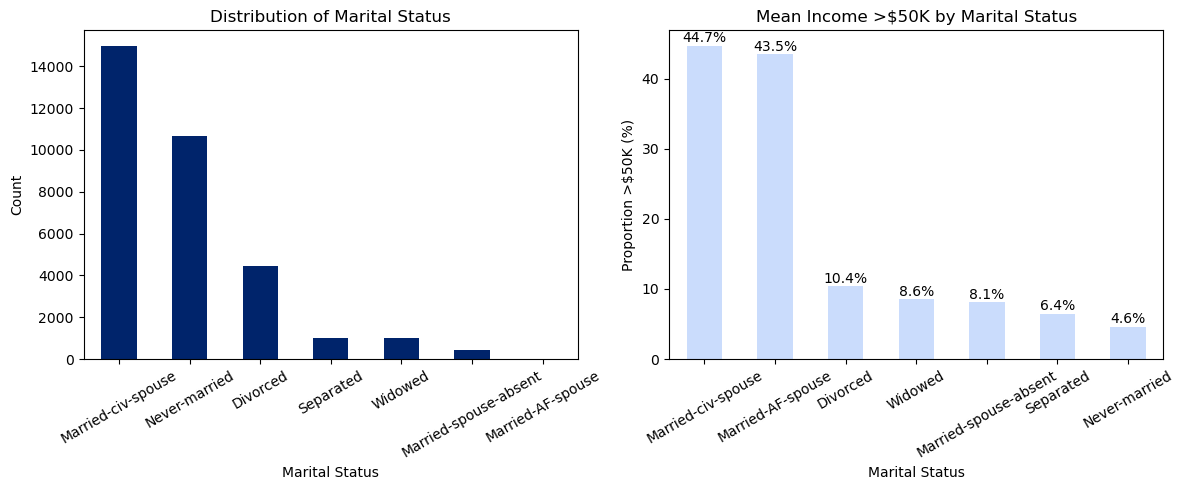

In [ ]:
# mean income by marital status

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Count of each marital status
marital_counts = df['marital-status'].value_counts().sort_values(ascending=False)
marital_counts.plot(kind='bar', color='#00246B', ax=axes[0])
axes[0].set_title('Distribution of Marital Status')
axes[0].set_xlabel('Marital Status')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=30)

# Mean income by marital status
marital_income = df.groupby('marital-status', observed=False)['income'].mean().sort_values(ascending=False) * 100
marital_income.plot(kind='bar', color='#CADCFC', ax=axes[1])
axes[1].set_title('Mean Income >$50K by Marital Status')
axes[1].set_xlabel('Marital Status')
axes[1].set_ylabel('Proportion >$50K (%)')
axes[1].tick_params(axis='x', rotation=30)
for i, v in enumerate(marital_income):
    axes[1].text(i, v + 0.5, f"{v:.1f}%", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

The plot suggests that creating a binary feature for married vs. non-married, although we will treat the group Married-spouse-absent, i.e. legally married but not living with spouse (spouse is absent, e.g., separated but not divorced) as non-married.

In [ ]:
married_statuses = ['Married-civ-spouse', 'Married-AF-spouse']
df['is_married'] = df['marital-status'].isin(married_statuses).astype(int)
df.drop('marital-status', axis=1, inplace=True)
print("\nValue counts for the new 'is_married' feature:\n")
print(df['is_married'].value_counts())


Value counts for the new 'is_married' feature:

is_married
0    17544
1    14993
Name: count, dtype: int64


In [ ]:
# merge husband and wife into spouse in relationship variable to further reduce cardinality for onehot encoding
df['relationship'] = df['relationship'].astype(str).replace({'Husband': 'Spouse', 'Wife': 'Spouse'}).astype('category')

# merge without-pay, never-worked categories into other to further reduce cardinality for onehot encoding
df['workclass'] = df['workclass'].astype(str).replace(['Without-pay', 'Never-worked'], 'Other').astype('category')

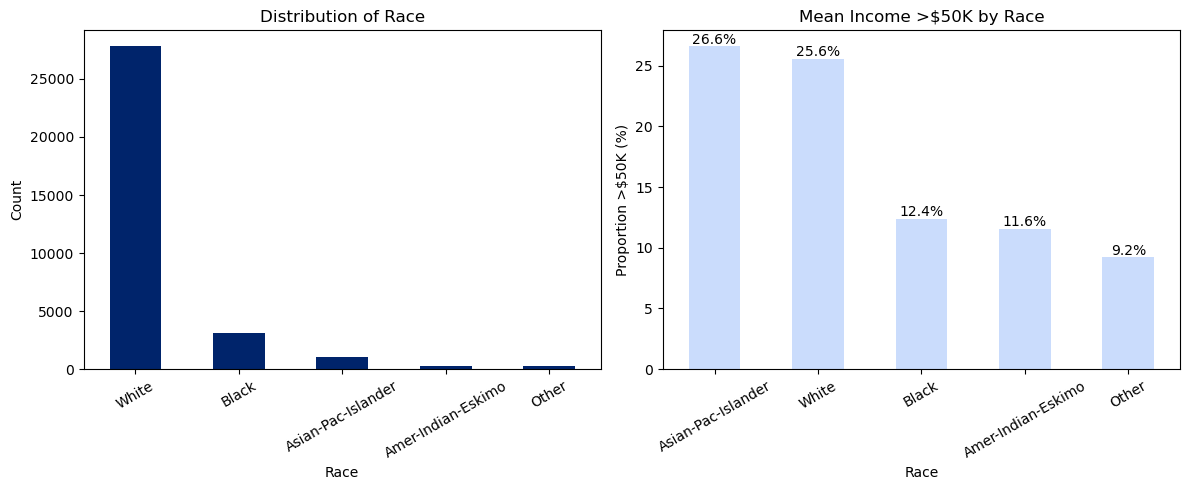

In [ ]:
# race distribution and mean income by race
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# count of each race
race_counts = df['race'].value_counts().sort_values(ascending=False)
race_counts.plot(kind='bar', color='#00246B', ax=axes[0])
axes[0].set_title('Distribution of Race')
axes[0].set_xlabel('Race')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=30)

# mean income by race
race_income = df.groupby('race', observed=False)['income'].mean().sort_values(ascending=False) * 100
race_income.plot(kind='bar', color='#CADCFC', ax=axes[1])
axes[1].set_title('Mean Income >$50K by Race')
axes[1].set_xlabel('Race')
axes[1].set_ylabel('Proportion >$50K (%)')
axes[1].tick_params(axis='x', rotation=30)
for i, v in enumerate(race_income):
    axes[1].text(i, v + 0.2, f"{v:.1f}%", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
# merge Amer-Indian-Eskimo and Other categories into other to further reduce cardinality for onehot encoding
df['race'] = df['race'].astype(str).replace({'Amer-Indian-Eskimo': 'Other'}).astype('category')

The merging of categories in features like race, relationship, and workclass leads to only a small reduction in dimensionality, but is justified because the combined groups are both small and statistically similar in terms of income distribution. This reduces noise and the risk of overfitting, while preserving the main socioeconomic patterns in the data. By merging only where appropriate, we maintain interpretability and model performance without unnecessary simplification.

In [ ]:
# number of distinct values in our categorical cols -> what feature encoding strat to use
categorical_vars = ['workclass', 'relationship', 'race', 'sex', 'education', 'occupation']

for var in categorical_vars:
    if var in df.columns:
        unique_vals = df[var].unique()
        print(f"{var}: {len(unique_vals)} unique values:\n {list(unique_vals)}\n")

workclass: 8 unique values:
 ['State-gov', 'Self-emp-not-inc', 'Private', 'Federal-gov', 'Local-gov', 'Missing', 'Self-emp-inc', 'Other']

relationship: 5 unique values:
 ['Not-in-family', 'Spouse', 'Own-child', 'Unmarried', 'Other-relative']

race: 4 unique values:
 ['White', 'Black', 'Asian-Pac-Islander', 'Other']

sex: 2 unique values:
 ['Male', 'Female']

education: 16 unique values:
 ['Bachelors', 'HS-grad', '11th', 'Masters', '9th', 'Some-college', 'Assoc-acdm', 'Assoc-voc', '7th-8th', 'Doctorate', 'Prof-school', '5th-6th', '10th', '1st-4th', 'Preschool', '12th']

occupation: 15 unique values:
 ['Adm-clerical', 'Exec-managerial', 'Handlers-cleaners', 'Prof-specialty', 'Other-service', 'Sales', 'Craft-repair', 'Transport-moving', 'Farming-fishing', 'Machine-op-inspct', 'Tech-support', 'Missing', 'Protective-serv', 'Armed-Forces', 'Priv-house-serv']



### 3.2 Data Splitting

To prevent data leakage, we must split the data into training and testing sets *before* any encoding or scaling. Previously, this mistake lead to artificially good performance on the validation set. All fitting steps (like for encoders and scalers) will be performed on the training set only and then applied to both the training and test sets.

In [ ]:
from utils.splits import train_test_split

# returns the full dataset (X, y)
df, train_df, test_df = train_test_split(
    df, 
    training_data_fraction=0.8, 
    class_column_name='income',
    shuffle=True, 
    return_numpy=False # dataframes instead of numpy arrays
)

print("Train df shape:", train_df.shape)
print("Test df shape:", test_df.shape)

Train df shape: (26030, 16)
Test df shape: (6507, 16)


### 3.3 Feature Encoding strategies

Feature encoding transforms categorical variables into numerical values for machine learning models. We will apply one-hot and ordinal encoding first, followed by a careful application of target encoding to prevent data leakage.

Brief explanation of all the strategies for encoding:

#### 1. One-Hot Encoding

- **Def.:** For a feature with $k$ categories, create $k-1$ binary columns:
  $$
  \text{OneHot}(x = c_j) = [0, \ldots, 1, \ldots, 0] \in \mathbb{R}^{k-1}
  $$
  where the $j$-th position is $1$ if $x = c_j$, else $0$.
- **Example:** If `race` has categories `[White, Black, Asian]` and $x = \text{Black}$, then $\text{OneHot}(x) = [1, 0]$.
- **When/Why:** Use for nominal (unordered) features to avoid implying order. We create $k-1$ columns instead of $k$ to avoid **perfect multicollinearity**, where one feature can be perfectly predicted by the others. This is crucial for linear models. The dropped category  (the most frequent one) becomes the baseline reference.

---

#### 2. Ordinal Encoding

- **Def.:** Map ordered categories to integers:
  $$
  \text{Ordinal}(x = c_j) = j
  $$
  where $j$ is the position in the predefined order.
- **Example:** If `education` order is `[HS-grad, Bachelors, Masters]$ and $x = \text{Bachelors}$, then $\text{Ordinal}(x) = 1$.
- **When/Why:** Use for ordinal features where order matters.

---

#### 3. Target Encoding

- **Def.:** Replace each category with the mean target value:
  $$
  \text{TargetEnc}(x = c_j) = \mathbb{E}[y \mid x = c_j]
  $$
- **Example:** If mean income for `occupation = Tech` is $0.32$, then $\text{TargetEnc}(\text{Tech}) = 0.32$.
- **When/Why:** Use for high-cardinality features; captures target signal but risk of leakage (use cross-validation).

---

#### 4. Frequency Encoding

- **Def.:** Replace each category with its frequency:
  $$
  \text{FreqEnc}(x = c_j) = \frac{\text{count}(x = c_j)}{N}
  $$
  where $N$ is the total number of samples.
- **Example:** If `country = US` appears in $70\%$ of rows, then $\text{FreqEnc}(\text{US}) = 0.7$.
- **When/Why:** Use for high-cardinality features; simple, no leakage.

In [ ]:
from utils.preprocessing import encode_features

# encoding strategies for each column we need to encode
encoding_strategies = {
    'one-hot': {'workclass' : 'Private', # second entry is dropped to avoid multicollinearity
                'relationship' : 'Spouse',
                'race' : 'White',
                'sex' : 'Male'},
    'ordinal': {'education': ['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th', 'HS-grad',
                               'Some-college', 'Assoc-voc', 'Assoc-acdm', 'Bachelors', 'Masters', 'Prof-school',
                               'Doctorate']},
    'target': {'occupation': 'income'}  # Format: {feature_to_encode: target_column}
}

# learn the parameters for test data transformation
train_df_encoded, fit_params = encode_features(train_df, encoding_strategies)

# transform test data with learned parameters
test_df_encoded = encode_features(test_df, encoding_strategies, fit_params=fit_params)

# align columns
test_df_encoded = test_df_encoded.reindex(columns=train_df_encoded.columns, fill_value=0)

# drop the education-num variable
train_df_encoded.drop('education-num', axis=1, inplace=True)
test_df_encoded.drop('education-num', axis=1, inplace=True)

# final shape
print("Train encoded shape:", train_df_encoded.shape)
print("Test encoded shape:", test_df_encoded.shape)

Train encoded shape: (26030, 26)
Test encoded shape: (6507, 26)


### 3.4 Correlation of Features with the target variable

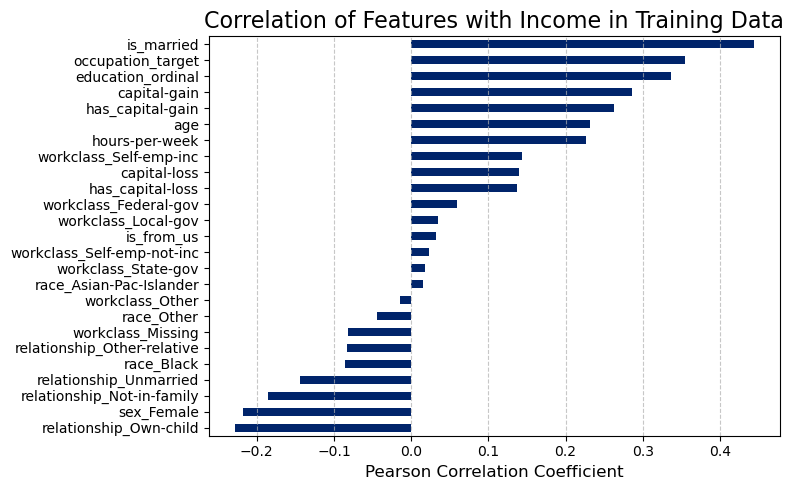

In [ ]:
# bar chart of correlations with income
correlation_matrix_encoded = train_df_encoded.corr()
income_correlations = correlation_matrix_encoded['income'].drop('income').sort_values()
plt.figure(figsize=(8, 5))
income_correlations.plot(kind='barh', color='#00246B')
plt.title('Correlation of Features with Income in Training Data', fontsize=16)
plt.xlabel('Pearson Correlation Coefficient', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Interpretation:

*   **Positive Correlation (Features on the right):** Features with a positive bar indicate that as the feature's value increases, the likelihood of having an income `>50K` also increases.
*   **Negative Correlation (Features on the left):** Features with a negative bar indicate that as the feature's value increases, the likelihood of having an income `>50K` decreases.

*   **Strongest Predictors:** `is_married`, `education` (ordinal), `age`, `hours-per-week`, and `capital-gain` show the strongest positive correlations. This aligns with our EDA findings: being married, having higher education, being older, and working more hours are all strongly associated with higher income. The target-encoded `occupation` feature is also a very strong predictor by design.

*   **Negative Predictors:** The strongest negative correlations come from one-hot encoded features like `relationship_Own-child` and `relationship_Not-in-family`. This indicates that individuals in these relationship categories are significantly less likely to have high income.


The dropped variables are the silent baseline against which all the other one-hot encoded columns from that same feature are measured. Their relationships are not directly visible in the matrix, but are implicitly defined by the relationships of the columns that are present. The relationship of the dropped `race_White` category is the inverse of the combined effect of the other categories. Because `race_White` is the most frequent category, the other, smaller race categories being negatively correlated with income implies that the large, baseline `race_White` category must have a correlation that is neutral or slightly positive to balance things out.

### 3.5 Data Splitting into features and target

In [ ]:
# separate into features (X) and target (y)
X_train = train_df_encoded.drop('income', axis=1)
y_train = train_df_encoded['income']
X_test = test_df_encoded.drop('income', axis=1)
y_test = test_df_encoded['income']

# convert to numpy
X_train = X_train.astype(float).to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.astype(float).to_numpy()
y_test = y_test.to_numpy()

# shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# balanced of the target variables
print("Train class balance:", np.mean(y_train))
print("Test class balance:", np.mean(y_test))

X_train shape: (26030, 25)
X_test shape: (6507, 25)
y_train shape: (26030,)
y_test shape: (6507,)
Train class balance: 0.23987706492508643
Test class balance: 0.24512063931151068


### 3.6 Feature Scaling

Before training our models, it's important to scale our numerical features. Of course, it makes no sense to also scale the freshly encoded categorical data, such as the ordinally encoded `education` variable as we would destroy its ordinal structure immediately again.  Models like Logistic Regression are sensitive to the scale of the input data, and scaling can lead to faster convergence and better performance. We will use standardization, where each feature is scaled to have a mean of 0 and a standard deviation of 1.

We will fit the scaler on the training data and use the same scaler to transform the test data. This prevents any information from the test set from leaking into our training process.


In [ ]:
# all columns in the data set
train_df_encoded.columns

Index(['age', 'capital-gain', 'capital-loss', 'hours-per-week', 'income',
       'has_capital-gain', 'has_capital-loss', 'is_from_us', 'is_married',
       'education_ordinal', 'occupation_target', 'workclass_Federal-gov',
       'workclass_Local-gov', 'workclass_Missing', 'workclass_Other',
       'workclass_Self-emp-inc', 'workclass_Self-emp-not-inc',
       'workclass_State-gov', 'relationship_Not-in-family',
       'relationship_Other-relative', 'relationship_Own-child',
       'relationship_Unmarried', 'race_Asian-Pac-Islander', 'race_Black',
       'race_Other', 'sex_Female'],
      dtype='object')

In [ ]:
from utils.normalization import StandardScaler

# numerical columns for scaling (excluding binary variables here)
numerical_cols = ['capital-gain', 'capital-loss', 'age', 'hours-per-week',
                  'education_ordinal', 'occupation_target']
X_columns = train_df_encoded.drop('income', axis=1).columns
numerical_indices = [X_columns.get_loc(col) for col in numerical_cols]

# initialize scaler for numerical columns (standardization is implemented)
scaler = StandardScaler(numerical_indices=numerical_indices)

# fit on training data - transform both training and test data with same scalar -> no data leakage
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 4. Model Training (Logistic Regression, Decision Tree, SVM)

Predict whether an individual's income exceeds $50,000 per year.

### Models Included:
- **Logistic Regression**: A linear model suitable for binary classification, optimized using gradient descent.
- **Linear SVM**: A margin-based classifier that separates classes using a hyperplane, implemented with a custom optimizer.

### Implementation Notes:
- All models are implemented using custom classes from the `courselib` package.
- Logistic Regression and SVM require **numerical input**, so categorical features are encoded appropriately beforehand.
- For SVM training, labels are converted from {0, 1} to {-1, 1}, as required by the hinge loss formulation.

### Evaluation Metrics:
- **Accuracy**: The proportion of total correct predictions.
  $$ \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN} $$
- **Precision**: The accuracy of positive predictions.
  $$ \text{Precision} = \frac{TP}{TP + FP} $$
- **Recall (Sensitivity)**: The ability of the model to find all the positive samples.
  $$ \text{Recall} = \frac{TP}{TP + FN} $$
- **Training Time**: time taken to train the model to evaluate efficiency.
- **Confusion Matrix**: A table visualizing the counts of TP, TN, FP, and FN.



In [ ]:
from models.glm import LogisticRegression
from models.svm import LinearSVM
from optimizers import GDOptimizer
from utils.training import ModelTraining, GridSearch
from utils.metrics import accuracy, precision_score, recall_score


# model params
n_features = X_train_scaled.shape[1]
w_init = np.zeros(n_features)
b_init = 0.0
optimizer = GDOptimizer(learning_rate=0.01)

# to save the results from training
results = []

# metrics
metrics_dict = {
    "Accuracy": lambda y_true, y_pred: accuracy(y_pred, y_true, one_hot_encoded_labels=False),
    "Precision": precision_score,
    "Recall": recall_score,
}

# model configurations
model_configs = [
    {
        'model_class': LogisticRegression,
        'model_name': 'Logistic Regression',
        'init_params': {
            'w': w_init.copy(), 
            'b': b_init, 
            'optimizer': GDOptimizer(learning_rate=0.01),
            'penalty': 'none', # 'none', 'ridge', 'lasso'
            'lam': 0.0
        },
        'fit_params': {'num_epochs': 20, 'batch_size': 32}
    }
]

# specify the models to train
models_to_train = []
for config in model_configs:
    model_to_train = ModelTraining(
        model_class=config['model_class'],
        model_name=config['model_name'],
        init_params=config['init_params'],
        metrics_dict=metrics_dict,
        **config['fit_params']
    )
    models_to_train.append(model_to_train)

### 4.1 Base model with detailed evaluation

First train only one model with logistic regression and without cross-validation to analyse that in detail. Then with 5-fold cv for more accurate results.

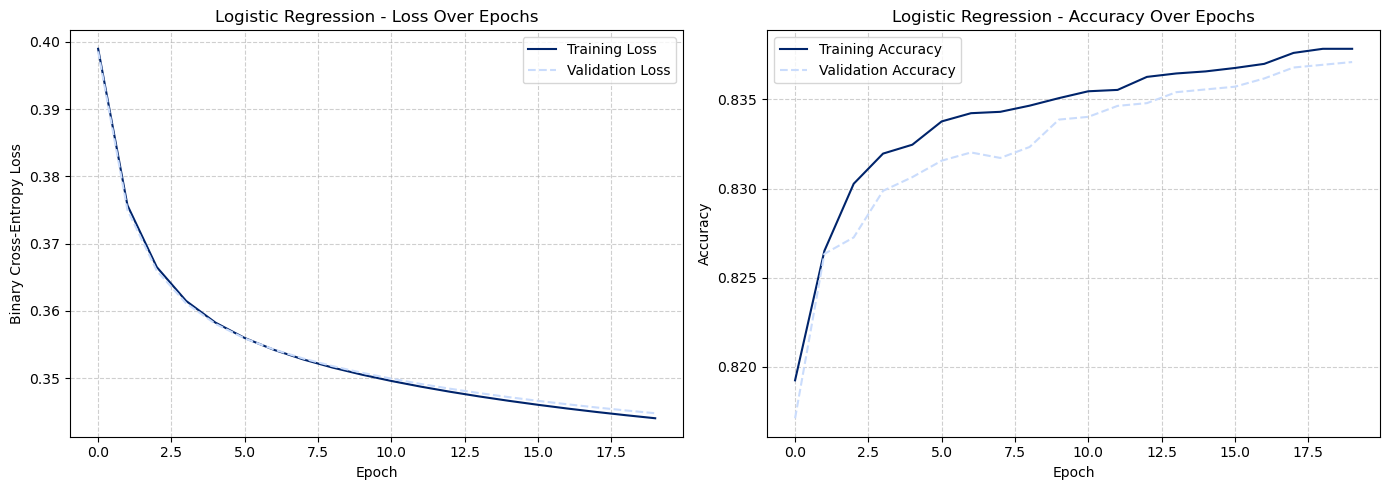

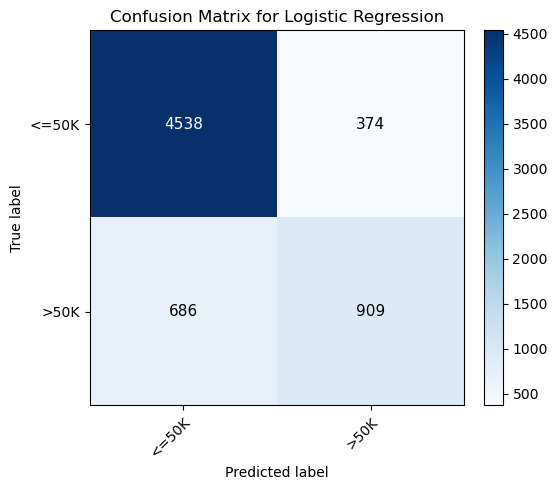

In [ ]:
from utils.metrics import plot_training_history

# training process of one model without cv
for model_to_train in models_to_train:
    
    # train the model using the params defined in the dict
    model_to_train.train(X_train_scaled, y_train, X_test_scaled, y_test)
    
    # Plot training history
    if model_to_train.history:
        print(100*'=')
        plot_training_history(model_to_train.history, model_to_train.model_name)
        print(100*'=')

    # eval on the test set and store results
    performance = model_to_train.evaluate(X_test_scaled, y_test)
    results.append(performance)
    print("="*60)

In [ ]:
# results for the simple training run
results_df = pd.DataFrame(results)
display(results_df)

,Model,Training Time (s),Accuracy,Precision,Recall
0,Logistic Regression,0.88873,83.709851,0.708496,0.569906


In [ ]:
# train the models via 5-fold cv now
all_cv_results = []
for model_to_train in models_to_train:
    # k-fold cross-validation for current model
    cv_result = model_to_train.cross_validate(X_train_scaled, y_train, k_folds=5)
    all_cv_results.append(cv_result)
    print("="*60)

CV for Logistic Regression with 5 folds
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


In [ ]:
# final summary of the cv
cv_results_df = pd.DataFrame(all_cv_results)
print("\n--- Overall Cross-Validation Summary ---")
display(cv_results_df)


--- Overall Cross-Validation Summary ---


,Model,Mean Accuracy,Std Accuracy,Mean Precision,Std Precision,Mean Recall,Std Recall,Mean Training Time (s),Std Training Time (s)
0,Logistic Regression,83.603534,0.280893,0.701087,0.021615,0.550287,0.017242,1.347054,0.476405


#### Why all those metrics
- Accuracy can be misleading: a model could achieve ~76% accuracy by simply always predicting the majority class (<=50K), making it useless.
- Precision: "Of all the people we predicted would have high income, how many actually did?" Important if the cost of a false positive is high.
- Recall: "Of all the people who actually have high income, how many did we find?" Important if the cost of a false negative is high.
- Confusion Matrix: provides the raw numbers (TP, TN, FP, FN) from which all the other metrics are calculated

## 6 Hyperparameter-Tuning

In [ ]:
# parameter grids for each model
param_grids = {
    "Logistic Regression": {
        "learning_rate": [0.001, 0.01, 0.1, 1],
        "num_epochs": [10, 20],
        "batch_size": [16, 32]
    },

    # "Linear SVM": {
    #     "C": [0.1, 1.0, 10.0],
    #     "learning_rate": [0.001, 0.01],
    #     "num_epochs": [5, 10],
    #     "batch_size": [16, 32]
    # }
}

In [ ]:
# gridsearch configs for each model
models_for_grid = [
    {
        "name": "Logistic Regression",
        "model_class": LogisticRegression,
        "param_grid": param_grids["Logistic Regression"],
        "init_params": {
            "w": np.zeros(X_train_scaled.shape[1]),
            "b": 0.0,
            "optimizer": None,  # will be set in grid
            "class_labels": [0, 1]
        }
    },
    # {
    #     "name": "Linear SVM",
    #     "model_class": LinearSVM,
    #     "param_grid": param_grids["Linear SVM"],
    #     "init_params": {
    #         "w": np.zeros(X_train_scaled.shape[1]),
    #         "b": 0.0,
    #         "optimizer": None,  # will be set in grid
    #         "C": 1.0
    #     }
    # }
]

In [ ]:
# run grid search for each model
for model_cfg in models_for_grid:
    print(f"Grid Search for: {model_cfg['name']}")

    # courselib gridsearch
    grid = GridSearch(
        model_class=model_cfg["model_class"],
        param_grid=model_cfg["param_grid"],
        fixed_params=model_cfg["init_params"],
        scoring="accuracy"
    )
    # for SVM: convert y_train to {-1, 1}
    y_train_grid = y_train.copy()
    if model_cfg["name"] == "Linear SVM":
        y_train_grid = y_train_grid.copy()
        y_train_grid[y_train_grid == 0] = -1

    # If optimizer is a grid param, handle it
    def preprocess_params(params):
        if "learning_rate" in params:
            params["optimizer"] = GDOptimizer(learning_rate=params.pop("learning_rate"))
        return params

    grid.preprocess_params = preprocess_params  # If your GridSearch supports this hook

    grid.fit(X_train_scaled, y_train_grid, X_val=X_test_scaled, y_val=y_test)
    print("Best Params:", grid.best_params_)
    print("Best Score:", grid.best_score_)
    print("Results DataFrame:")
    display(grid.cv_results_)  # Or print(grid.cv_results_) if not in Jupyter

Grid Search for: Logistic Regression


TypeError: TrainableModel.fit() got an unexpected keyword argument 'class_labels'

In [ ]:
# === Analyze coefficients from Logistic Regression ===

# Retrieve the trained Logistic Regression model from ModelTraining wrapper
logreg = models_to_train[0].model

# Extract the weight vector and feature names
coefs = logreg.w
feature_names = X_columns

# Create a DataFrame for easier inspection
coef_df = pd.DataFrame({'feature': feature_names, 'coefficient': coefs})

# Show top 10 most positive and most negative coefficients
top_pos = coef_df.sort_values(by='coefficient', ascending=False).head(10)
top_neg = coef_df.sort_values(by='coefficient').head(10)

print("Top Positive Coefficients:")
print(top_pos)

print("\nTop Negative Coefficients:")
print(top_neg)


## 6. Categorical Feature Analysis

To determine the best encoding strategy, we can analyze the relationship between each categorical feature and the target variable (`income`). We'll calculate the mean income for each category to see if there's a natural ordering.


In [ ]:

# Analyze the relationship between categorical features and income
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
if 'income' in categorical_cols:
    categorical_cols.remove('income') # Remove target variable

for col in categorical_cols:
    
    income_rate = df.groupby(col)['income'].mean().sort_values()
    plt.figure(figsize=(10, 6))
    income_rate.plot(kind='barh', color='#00246B')
    plt.title(f"Proportion of >50K by {col}")
    plt.xlabel("Proportion of income > 50K")
    plt.tight_layout()
    plt.show()
    print(f"--- {col} ---")
    # Group by the column and calculate the mean of the target variable
    # We can do this because the target is 0 or 1
    print(df.groupby(col)['income'].mean().sort_values(ascending=False))
    print("\n")

summary = df.groupby(col).agg(
    income_rate=('income', 'mean'),
    count=('income', 'size')
).sort_values(by='income_rate', ascending=False)